<a href="https://colab.research.google.com/github/gpricechristie/introductionToClinicalTrials/blob/main/simulateTrials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simulation of different clinical trial designs
Load a simulated cancer pateint population, sample from the population and assess the impact of different designs on the study analysis

Basic patient factors in the population are:
* Age
* Sex
* Performance status
* Cancer stage
* GTV Volume


Load libraries

In [1]:
install.packages("ggsurvfit")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
install.packages("table1")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(survival)
library(ggplot2)
library(ggsurvfit)
library(tidyr)
library(table1)
library(patchwork)
library(dplyr)


Attaching package: ‘table1’


The following objects are masked from ‘package:base’:

    units, units<-



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Load population data

In [4]:
population = read.csv('simulatedPopulation.csv')

Create demographic table and plot descriptive statistics

In [ ]:
tab1 = table1(~ age + sex + ps + stage + gtv, population)

Warning message:
“Removed 590 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


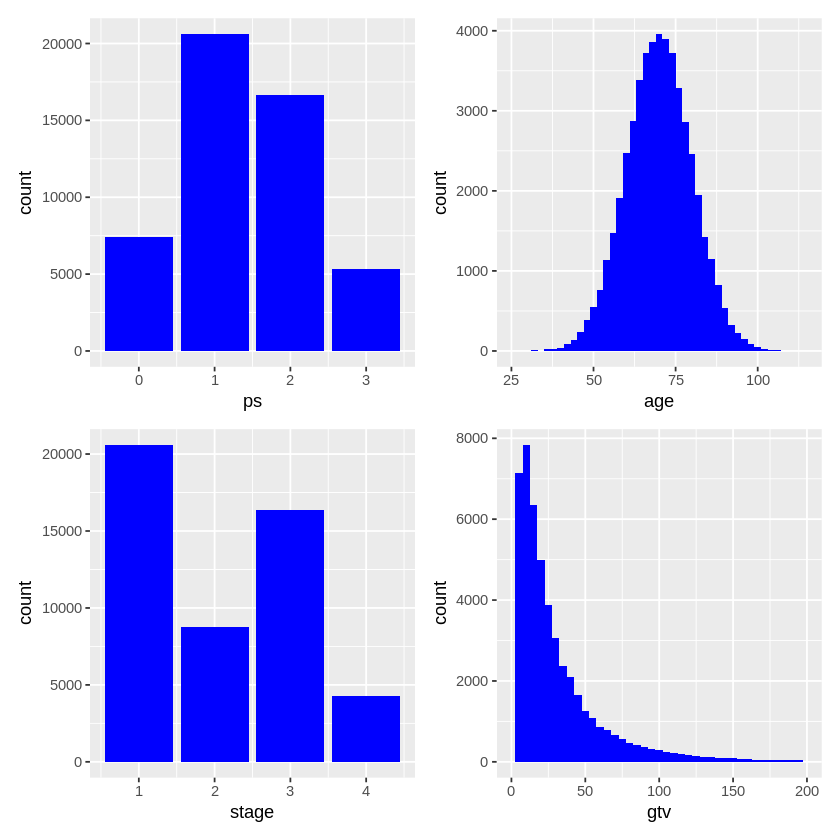

In [ ]:
p1 = ggplot(population,aes(x=ps)) +
  geom_bar(stat='count', fill='blue')
p2 = ggplot(population,aes(x=age)) +
  geom_histogram(fill='blue',binwidth=2)
p3 = ggplot(population,aes(x=stage)) +
  geom_bar(stat='count', fill='blue')
p4 = ggplot(population,aes(x=gtv)) +
  geom_histogram(fill='blue',binwidth=5) +
  xlim(c(0,200))
p1+p2+p3+p4

Set basic parameters


*   Number of patients to sample from population (nbrPats)
*   Baseline hazard for simulation of survival times (h_0 - uniform as exponential cumulative baseline)



In [5]:
nbrPats = 1000
popSize=nrow(population)
h_0=0.001

Create time vector for period we are interested in (3 years)

In [6]:
time=seq(0,365*3)

Calculate cumulative baseline hazard

In [7]:
H_0 = h_0 * time

#Clinical scenarios
Provide new intervention under different scenarios and evaluate its impact on survival

Sample patients from the wider population to include in study

In [9]:
set.seed(86112)
patients=population[as.integer(runif(nbrPats)*popSize),]


##Treatment assigned by hospital


Assign patients to catchement area for:
* Hospital A - catchment area predominantly affluent suburbs
* Hospital B - catchment area includes more deprived inner city regions

In [10]:
age_norm = (patients$age-min(patients$age))/(max(patients$age)-min(patients$age))
ps_norm = as.numeric(patients$ps)/3
stage_norm = (as.numeric(patients$stage)-1)/3

hospital = 1.3*age_norm + ps_norm + stage_norm + rnorm(n=nbrPats, mean=0, sd=0.3)
hospital = (hospital-min(hospital))/(max(hospital)-min(hospital))
patients$hospital = rep('A',length(hospital))
patients$hospital[which(hospital>median(hospital))]='B'

Hospital A introduces the new treatment for all patients whereas it is not available in the hospital serving the less wealthy region

Assign treatment variable by hospital

In [11]:

patients$treat = rep('Standard of Care',nrow(patients))
patients$treat[which(patients$hospital=='A')]='Intervention'


Add treatment to prognostic index

In [12]:
patients$treat_pi = log(patients$hr_treat) * (patients$treat == 'Intervention')
patients$progInd = patients$baseProgInd + patients$treat_pi

Calculate the individual hazard per patient over time

In [ ]:
hazard = array(dim=c(length(time),nrow=nbrPats))
for(i in 1:nbrPats){
  hazard[,i] =  H_0 * exp(patients$progInd[i])
}

Calculate survival probabilities per patient from their hazard and the baseline S_i = exp(-hazard)

Plot to see if it looks sensible



In [ ]:
surv = exp(-hazard)
surv_df = data.frame(id=rep(seq(nbrPats), each=nrow(surv)), time=rep(time, ncol(surv)), surv_prob=as.vector(surv))
ggplot(data=surv_df,aes(x=time, y=surv_prob, group=id)) +
  geom_line(alpha=0.05)

Now need to simulate survival times by using probabilities taken from a uniform random number generator for each patient

They then survive until the corresponding time equating to the survival probability calculated from their individual hazard radio

S(t) = exp(-H_0(t) * exp(progInd)) where we calculate S(t) from random distribution for each patient

log(S(t)) = -h_0 * time * exp(progInd)

time = - log(S(t)) / h_0*exp(progInd)

In the first instance set all patinets to having an event (ie we know when all die). We can censoir later if required

In [13]:
survProb = runif(nbrPats,0,1)
patients$survTime = -log(survProb) / (h_0 * exp(patients$progInd))
patients$vitalStatus = rbinom(n=nrow(patients), size=1, prob=0.9)

Use ggplot to plot KM curve

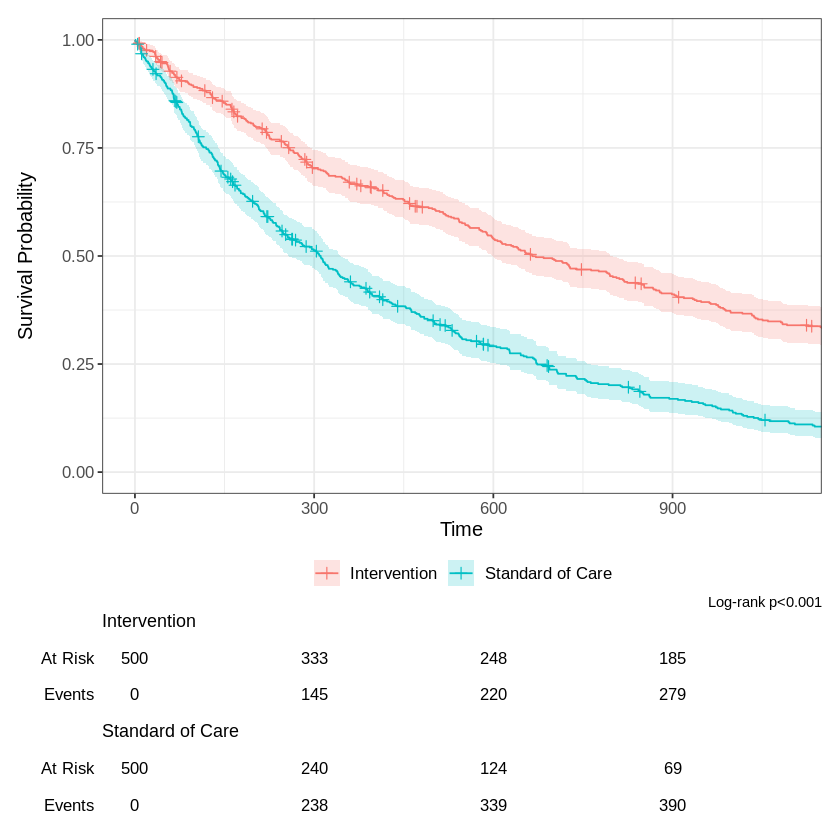

In [14]:
hospitalSurv = Surv(patients$survTime,patients$vitalStatus)

ggsurvfit(survfit2(hospitalSurv~treat, data=patients), type = "survival") +
  add_censor_mark() +
  add_confidence_interval() +
  add_risktable() +
  coord_cartesian(xlim = c(0, 365 * 3)) +
  add_pvalue(caption = "Log-rank {p.value}")


However, look at balance between those patients who recieved the new treatments (that attended hospital A) and those that didn't (that attended hospital B).

Note to get the below table to render (TODO: figure out how to render directly in notebook) you need to copy the html output to the empty text box below the code snippet

In [ ]:
print(table1(~ age + sex + ps + stage | treat, patients))

ERROR: Error: object 'patients' not found




<table class="Rtable1">
<thead>
<tr>
<th class='rowlabel firstrow lastrow'></th>
<th class='firstrow lastrow'><span class='stratlabel'>Intervention<br><span class='stratn'>(N=500)</span></span></th>
<th class='firstrow lastrow'><span class='stratlabel'>Standard of Care<br><span class='stratn'>(N=500)</span></span></th>
<th class='firstrow lastrow'><span class='stratlabel'>Overall<br><span class='stratn'>(N=1000)</span></span></th>
</tr>
</thead>
<tbody>
<tr>
<td class='rowlabel firstrow'>age</td>
<td class='firstrow'></td>
<td class='firstrow'></td>
<td class='firstrow'></td>
</tr>
<tr>
<td class='rowlabel'>Mean (SD)</td>
<td>65.6 (9.18)</td>
<td>74.2 (9.15)</td>
<td>69.9 (10.1)</td>
</tr>
<tr>
<td class='rowlabel lastrow'>Median [Min, Max]</td>
<td class='lastrow'>66.0 [39.7, 92.2]</td>
<td class='lastrow'>74.3 [46.0, 100]</td>
<td class='lastrow'>69.6 [39.7, 100]</td>
</tr>
<tr>
<td class='rowlabel firstrow'>sex</td>
<td class='firstrow'></td>
<td class='firstrow'></td>
<td class='firstrow'></td>
</tr>
<tr>
<td class='rowlabel'>female</td>
<td>204 (40.8%)</td>
<td>189 (37.8%)</td>
<td>393 (39.3%)</td>
</tr>
<tr>
<td class='rowlabel lastrow'>male</td>
<td class='lastrow'>296 (59.2%)</td>
<td class='lastrow'>311 (62.2%)</td>
<td class='lastrow'>607 (60.7%)</td>
</tr>
<tr>
<td class='rowlabel firstrow'>ps</td>
<td class='firstrow'></td>
<td class='firstrow'></td>
<td class='firstrow'></td>
</tr>
<tr>
<td class='rowlabel'>0</td>
<td>126 (25.2%)</td>
<td>19 (3.8%)</td>
<td>145 (14.5%)</td>
</tr>
<tr>
<td class='rowlabel'>1</td>
<td>248 (49.6%)</td>
<td>161 (32.2%)</td>
<td>409 (40.9%)</td>
</tr>
<tr>
<td class='rowlabel'>2</td>
<td>112 (22.4%)</td>
<td>217 (43.4%)</td>
<td>329 (32.9%)</td>
</tr>
<tr>
<td class='rowlabel lastrow'>3</td>
<td class='lastrow'>14 (2.8%)</td>
<td class='lastrow'>103 (20.6%)</td>
<td class='lastrow'>117 (11.7%)</td>
</tr>
<tr>
<td class='rowlabel firstrow'>stage</td>
<td class='firstrow'></td>
<td class='firstrow'></td>
<td class='firstrow'></td>
</tr>
<tr>
<td class='rowlabel'>1</td>
<td>302 (60.4%)</td>
<td>101 (20.2%)</td>
<td>403 (40.3%)</td>
</tr>
<tr>
<td class='rowlabel'>2</td>
<td>83 (16.6%)</td>
<td>90 (18.0%)</td>
<td>173 (17.3%)</td>
</tr>
<tr>
<td class='rowlabel'>3</td>
<td>107 (21.4%)</td>
<td>224 (44.8%)</td>
<td>331 (33.1%)</td>
</tr>
<tr>
<td class='rowlabel lastrow'>4</td>
<td class='lastrow'>8 (1.6%)</td>
<td class='lastrow'>85 (17.0%)</td>
<td class='lastrow'>93 (9.3%)</td>
</tr>
</tbody>
</table>



Plotted as graphs

Warning message:
“Removed 9 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


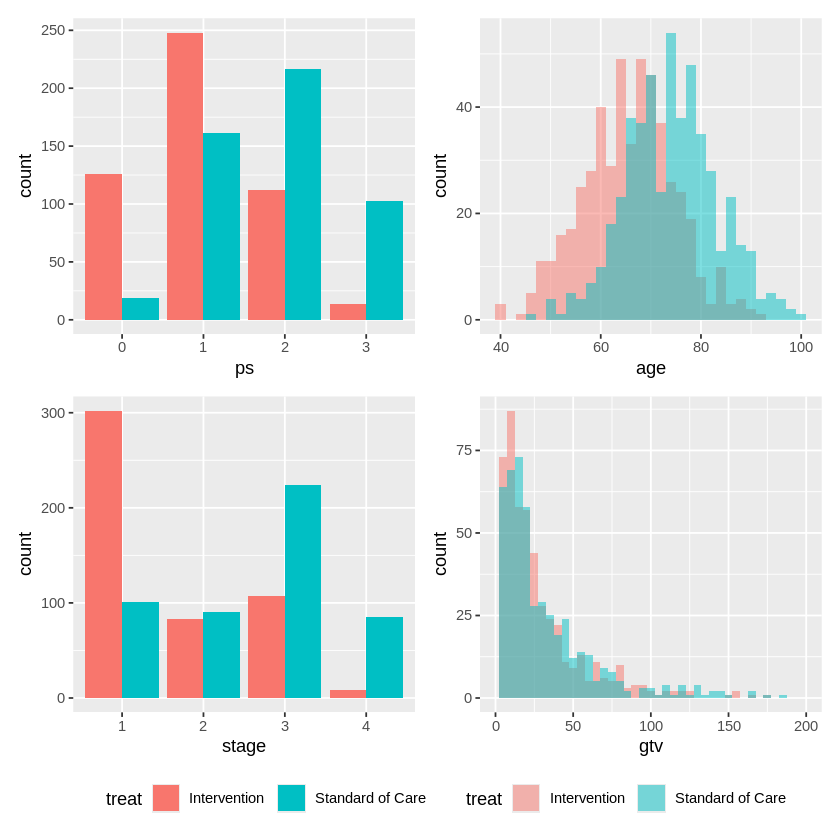

In [ ]:
p1 = ggplot(patients,aes(x=ps, group=treat, fill=treat)) +
  geom_bar(stat='count',position='dodge')
p2 = ggplot(patients,aes(x=age, group=treat, fill=treat)) +
  geom_histogram(binwidth=2,position = 'identity',alpha=0.5)
p3 = ggplot(patients,aes(x=stage, group=treat, fill=treat)) +
  geom_bar(stat='count',position='dodge')
p4 = ggplot(patients,aes(x=gtv, group=treat, fill=treat)) +
  geom_histogram(binwidth=5,position = 'identity',alpha=0.5) +
  xlim(0, 200)

combined <- p1 + p2 +p3 + p4 & theme(legend.position = "bottom")
combined + plot_layout(guides = "collect")

However, calculate the multivariable cox model and see what the regression coefficients say

In [ ]:
hospitalCox = coxph(hospitalSurv~ age + sex + ps + stage + log(gtv) + treat, data=patients)
summary(hospitalCox)

Call:
coxph(formula = hospitalSurv ~ age + sex + ps + stage + log(gtv) + 
    treat, data = patients)

  n= 1000, number of events= 895 

                          coef exp(coef) se(coef)      z Pr(>|z|)    
age                   0.015904  1.016032 0.003435  4.630 3.66e-06 ***
sexmale               0.185703  1.204064 0.069345  2.678 0.007407 ** 
ps                    0.166706  1.181407 0.044678  3.731 0.000191 ***
stage                 0.254811  1.290217 0.040287  6.325 2.54e-10 ***
log(gtv)              0.386350  1.471600 0.036838 10.488  < 2e-16 ***
treatStandard of Care 0.210576  1.234389 0.095848  2.197 0.028023 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                      exp(coef) exp(-coef) lower .95 upper .95
age                       1.016     0.9842     1.009     1.023
sexmale                   1.204     0.8305     1.051     1.379
ps                        1.181     0.8464     1.082     1.290
stage                     1.290     0.7751     1.192

##Treatment assigned randomly to all patients
In the next scenario, treatment is assigned randonly to all patients

The randomisation balances the groups meaning the log-rank test results closely agree with the multivariable regression

Create the new survival data

In [ ]:
patients$treat = rep('Standard of Care',nbrPats)
patients$treat[which(runif(nbrPats)>0.5)]='Intervention'

patients$treat_pi = log(patients$hr_treat) * (patients$treat == 'Intervention')
patients$progInd = patients$baseProgInd + patients$treat_pi

survProb = runif(nbrPats,0,1)
patients$survTime = -log(survProb) / (h_0 * exp(patients$progInd))
patients$vitalStatus = rbinom(n=nrow(patients), size=1, prob=0.9)

Look at KM curve

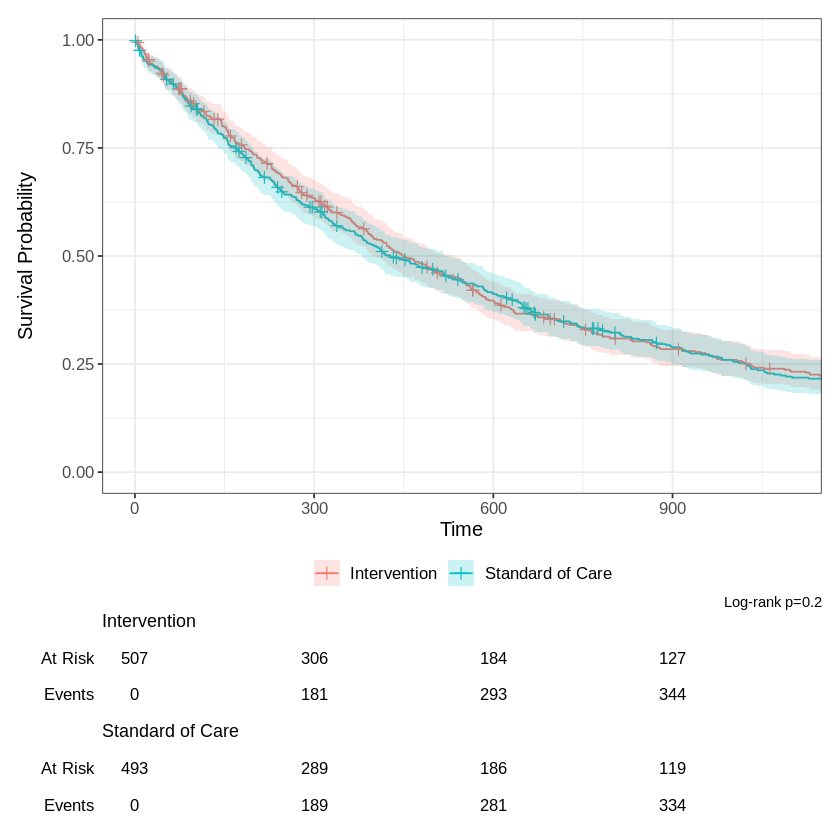

In [ ]:
randSurv = Surv(patients$survTime,patients$vitalStatus)

ggsurvfit(survfit2(randSurv~treat, data=patients), type = "survival") +
  add_censor_mark() +
  add_confidence_interval() +
  add_risktable() +
  coord_cartesian(xlim = c(0, 365 * 3)) +
  add_pvalue(caption = "Log-rank {p.value}")


Plot balance of groups

Warning message:
“Removed 9 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


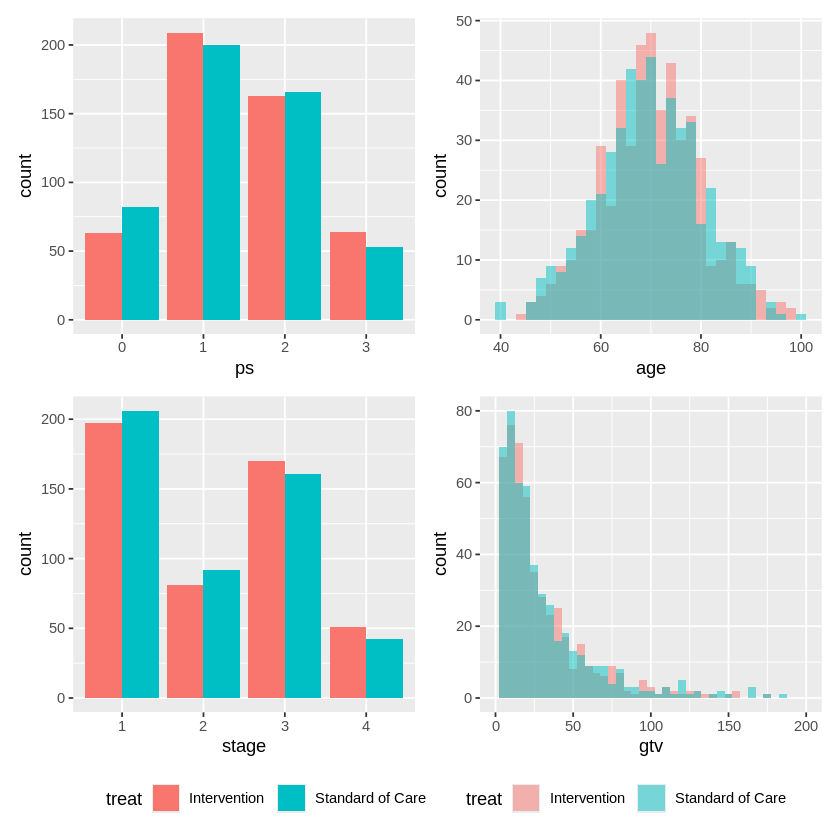

In [ ]:
p1 = ggplot(patients,aes(x=ps, group=treat, fill=treat)) +
  geom_bar(stat='count',position='dodge')
p2 = ggplot(patients,aes(x=age, group=treat, fill=treat)) +
  geom_histogram(binwidth=2,position = 'identity',alpha=0.5)
p3 = ggplot(patients,aes(x=stage, group=treat, fill=treat)) +
  geom_bar(stat='count',position='dodge')
p4 = ggplot(patients,aes(x=gtv, group=treat, fill=treat)) +
  geom_histogram(binwidth=5,position = 'identity',alpha=0.5) +
  xlim(0, 200)

combined <- p1 + p2 +p3 + p4 & theme(legend.position = "bottom")
combined + plot_layout(guides = "collect")

Check multi variable analysis

In [ ]:
randCox = coxph(randSurv~ age + sex + ps + stage + log(gtv) + treat, data=patients)
summary(randCox)

Call:
coxph(formula = randSurv ~ age + sex + ps + stage + log(gtv) + 
    treat, data = patients)

  n= 1000, number of events= 884 

                          coef exp(coef) se(coef)     z Pr(>|z|)    
age                   0.011002  1.011063 0.003464 3.176  0.00149 ** 
sexmale               0.215609  1.240618 0.070313 3.066  0.00217 ** 
ps1                   0.337656  1.401658 0.105636 3.196  0.00139 ** 
ps2                   0.499484  1.647871 0.113081 4.417 1.00e-05 ***
ps3                   0.675634  1.965278 0.138238 4.887 1.02e-06 ***
stage2                0.075732  1.078674 0.098400 0.770  0.44152    
stage3                0.328401  1.388746 0.082751 3.969 7.23e-05 ***
stage4                0.862947  2.370135 0.124773 6.916 4.64e-12 ***
log(gtv)              0.367871  1.444655 0.039073 9.415  < 2e-16 ***
treatStandard of Care 0.342546  1.408529 0.068993 4.965 6.87e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                      exp(coef) exp(-co

##Randomisation with selection criteria
In the final scenario we demonstrate why trials have selection criteria. As some patients respond differently to the new treatment, selection of only those patients expected to respond positively to the intervention can lead to more impressive results

Limit the treatment to those patients with
* Performance status 0-1
* Stage 1-3

In [ ]:
patients_included = population %>%
  dplyr::filter((ps == 0 | ps ==1) & (stage == 1 | stage == 2)) %>%
  slice_sample(n=nbrPats)

Randomise this subset of patients and repeat the analysis

In [ ]:
patients_included$treat = rep('Standard of Care',nbrPats)
patients_included$treat[which(runif(nbrPats)>0.5)]='Intervention'

patients_included$treat_pi = log(patients_included$hr_treat) * (patients_included$treat == 'Intervention')
patients_included$progInd = patients_included$baseProgInd + patients_included$treat_pi

survProb = runif(nbrPats,0,1)
patients_included$survTime = -log(survProb) / (h_0 * exp(patients_included$progInd))
patients_included$vitalStatus = rbinom(n=nbrPats, size=1, prob=0.9)

Look at KM curve and Cox regression, check cohort balance

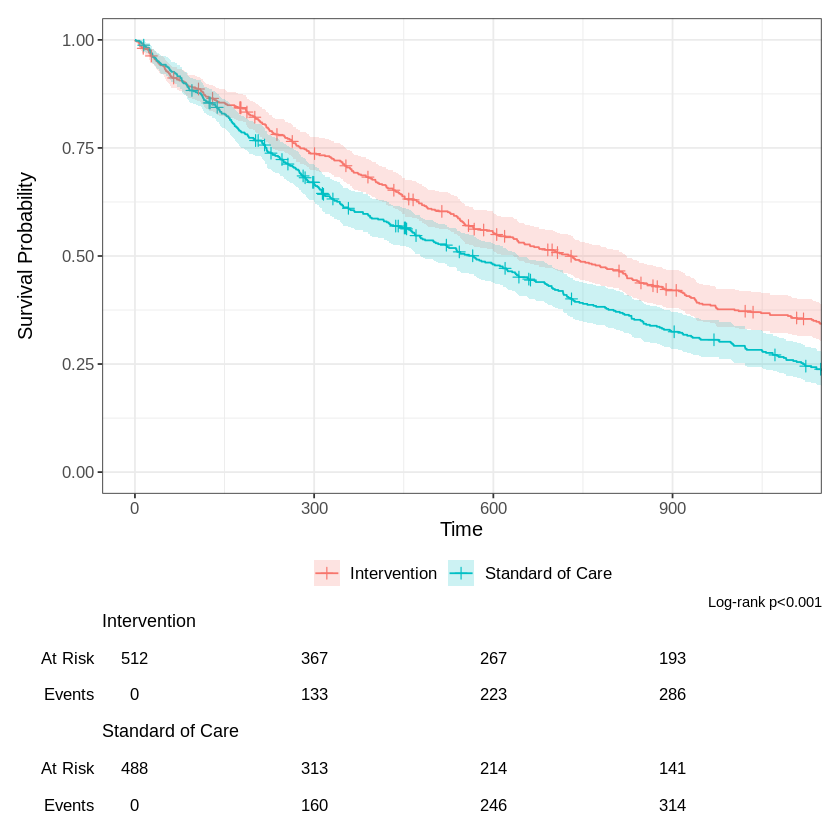

In [ ]:
selectSurv = Surv(patients_included$survTime,patients_included$vitalStatus)

ggsurvfit(survfit2(selectSurv~treat, data=patients_included), type = "survival") +
  add_censor_mark() +
  add_confidence_interval() +
  add_risktable() +
  coord_cartesian(xlim = c(0, 365 * 3)) +
  add_pvalue(caption = "Log-rank {p.value}")

In [ ]:
selectCox = coxph(selectSurv~ age + sex + ps + stage + log(gtv) + treat, data=patients_included)
summary(selectCox)

Call:
coxph(formula = selectSurv ~ age + sex + ps + stage + log(gtv) + 
    treat, data = patients_included)

  n= 1000, number of events= 901 

                          coef exp(coef) se(coef)     z Pr(>|z|)    
age                   0.009477  1.009522 0.003429 2.764 0.005714 ** 
sexmale               0.280528  1.323829 0.068236 4.111 3.94e-05 ***
ps1                   0.303925  1.355167 0.078806 3.857 0.000115 ***
ps2                         NA        NA 0.000000    NA       NA    
ps3                         NA        NA 0.000000    NA       NA    
stage2                0.248389  1.281958 0.074674 3.326 0.000880 ***
stage3                      NA        NA 0.000000    NA       NA    
stage4                      NA        NA 0.000000    NA       NA    
log(gtv)              0.277799  1.320221 0.036004 7.716 1.20e-14 ***
treatStandard of Care 0.247917  1.281354 0.067538 3.671 0.000242 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                      exp(co